The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:   12.5s finished


Accuracy for description feature:


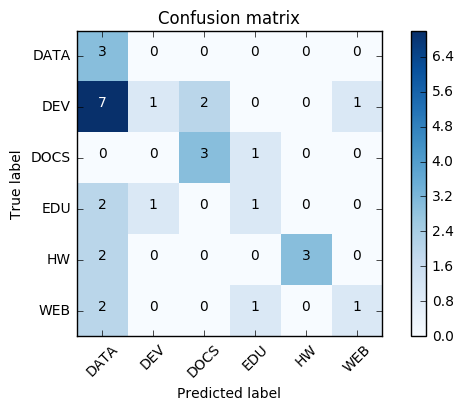

0.387096774194
['homework', 'app', 'application', 'notes', 'submission']
['HW' 'DEV' 'DATA' 'DATA' 'DEV']
Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 243 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 493 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 843 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  1.9min finished


Accuracy for readme feature:


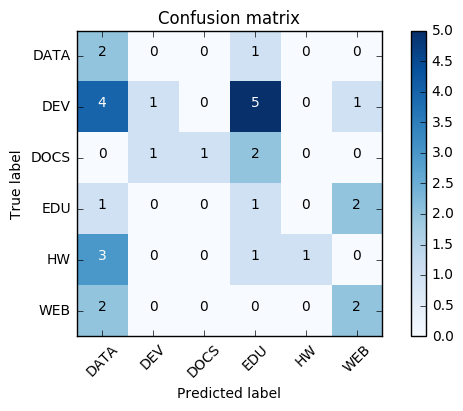

0.258064516129
['homework', 'app', 'application', 'notes', 'submission']
['HW' 'DEV' 'DEV' 'DOCS' 'DEV']


In [21]:
%load_ext autoreload
%autoreload 2
from evaluation import eval_classifier
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy

train_df = pd.read_csv("data/processed_data.csv")
val_df = pd.DataFrame.from_csv("data/validation_data.csv")
y_train = train_df.pop("label")
y_val = val_df.pop("label")
examples = ["homework", "app", "application", "notes", "submission"]

le = LabelEncoder().fit(y_train)
classes = le.classes_

for text_feature in ["description", "readme"]:  
    train_df[text_feature].fillna("", inplace=True)
    val_df[text_feature].fillna("", inplace=True)
    X_train = train_df[text_feature].values
    X_val = val_df[text_feature].values

    ppl = get_best_text_pipeline(X_train, y_train)
    print "Accuracy for {} feature:".format(text_feature)
    acc = eval_classifier(ppl, X_val, y_val, le.classes_)
    print acc
    print examples
    print ppl.predict(examples)